# RL Exercise 6 - Training with Ray and Serving with Clipper

**GOAL:** The goal of this exercise is to show how to train a policy with Ray and to deploy it with Clipper in a fun, interactive way.

We will train an agent to play Pong, and then we will play Pong against the policy that we trained.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gym
import pong_py
import ray
import cloudpickle

from ray.tune.registry import register_env
from ray.rllib.agents import ppo
import flor

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
flor.setNotebookName('flor_rl_exercise04.ipynb')

# Imitation Learning

In [ ]:
ex = flor.Experiment('integration_imitation_risecamp2018').__enter__()

In [ ]:
imitation_data = ex.artifact('imitation_data.csv', 'imitation_data')

In [ ]:
@flor.func
def preproc_imitation(imitation_data, procd_imitation_data, **kwargs):
    import pandas as pd
    df_data = pd.read_csv(imitation_data)
    df_data.columns = ["label","paddle_y","ball_x","ball_y","ball_dx","ball_dy","x_prev","y_prev"]

    def convert_label(label):
        """Convert labels into numeric values"""
        if(label=="down"):
            return 1
        elif(label=="up"):
            return 2
        else:
            return 0

    df_data['label'] = df_data['label'].apply(convert_label)
    df_data.loc[:, "paddle_y":"y_prev"] = df_data.loc[:, "paddle_y":"y_prev"]/500.0
    df_data.to_json(procd_imitation_data)

In [ ]:
do_preproc_imitation = ex.action(preproc_imitation, [imitation_data])

In [ ]:
procd_imitation_data = ex.artifact('imitation_data.json', 'procd_imitation_data', do_preproc_imitation)

In [ ]:
@flor.func
def train_imitation_model(procd_imitation_data, imitation_model, **kwargs):
    import cloudpickle
    import pandas as pd
    from sklearn import linear_model
    df_data = pd.read_json(procd_imitation_data)
    
    labels = df_data['label']
    training_data= df_data.drop(['label'], axis=1)

    model = linear_model.LogisticRegression()
    model.fit(training_data, labels)
    with open(imitation_model, 'wb') as f:
        cloudpickle.dump(model, f)

    

In [ ]:
do_train_imitation_model = ex.action(train_imitation_model, [procd_imitation_data])

In [ ]:
imitation_model = ex.artifact('model.pkl', 'imitation_model', do_train_imitation_model)

In [ ]:
ex.__exit__()

In [ ]:
imitation_model.plot()

In [ ]:
imitation_model.pull()

# Reinforcement Learning

In [3]:
ex = flor.Experiment('integration_rl_risecamp2018').__enter__()

Start Ray.

In [4]:
@flor.func
def start_ray(**kwargs):
    try:
        ray.get([])
    except:
        ray.init()    
    return {'exit_code': 0}

Instantiate an agent that can be trained using Proximal Policy Optimization (PPO).

In [5]:
@flor.func
def instantiate_agent(env_config, trainer, **kwargs):
    from os import rename
    register_env("my_env", lambda ec: pong_py.PongJSEnv())
    agent = ppo.PPOAgent(env="my_env", config={"env_config": {}})
    checkpoint_path = agent.save()
    rename(checkpoint_path, trainer)
    

Train the `PPOAgent` for some number of iterations.

**EXERCISE:** You will need to experiment with the number of iterations as well as with the configuration to get the agent to learn something reasonable.

Checkpoint the agent so that the relevant model can be saved and deployed to Clipper. We save the name of the checkpoint file in `metadata.json` so the model container knows how to restore the policy checkpoint.

In [6]:
@flor.func
def train_agent(num_iterations, trainer, checkpoint, **kwargs):
    from os import rename
    with open(trainer, 'rb') as f:
        agent = cloudpickle.load(f)
    for i in range(num_iterations):
        result = agent.train()

    checkpoint_path = agent.save()
    rename(checkpoint_path, checkpoint)

In [7]:
do_start_ray = ex.action(start_ray, [])

In [8]:
exit_code = ex.literal(name='exit_code', parent=do_start_ray)

In [9]:
env_config = ex.literal({}, 'env_config') # TODO: Fill env_config

In [10]:
do_instantiate_agent = ex.action(instantiate_agent, [env_config, exit_code])

In [11]:
trainer = ex.artifact('trainer.pkl', 'trainer', do_instantiate_agent)

In [12]:
num_iterations = ex.literal(2, 'num_iterations')

In [13]:
do_train_agent = ex.action(train_agent, [num_iterations, trainer])

In [14]:
checkpoint = ex.artifact('checkpoint.pkl', 'checkpoint', do_train_agent)

In [15]:
ex.__exit__()

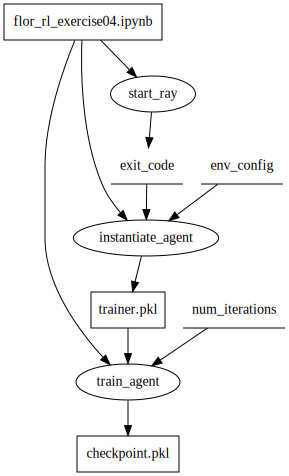

In [16]:
checkpoint.plot()

In [17]:
checkpoint.pull()

Process STDOUT and STDERR is being redirected to /tmp/raylogs/.
Waiting for redis server at 127.0.0.1:61281 to respond...
Waiting for redis server at 127.0.0.1:51820 to respond...
Starting local scheduler with the following resources: {'CPU': 2, 'GPU': 0}.

View the web UI at http://localhost:8889/notebooks/ray_ui39660.ipynb?token=e45c0ba0ea56c329dd722fda478f6f8fcf9ca26e4c7c4d87



Created LogSyncer for /home/jovyan/ray_results/2018-09-19_21-27-23r_ly0zxy -> None
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
LocalMultiGPUOptimizer devices ['/cpu:0']


FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/ray_results/2018-09-19_21-27-23r_ly0zxy/checkpoint-0' -> 'trainer_140013407058072.pkl'

In [19]:
!ls /home/jovyan/ray_results/2018-09-19_21-27-23r_ly0zxy/

checkpoint-0.extra_data     params.json   result.json
checkpoint-0.tune_metadata  progress.csv


## Play Against the Policy

In this section, we will play Pong against the policy that we just trained. The game will be played in your browser, and the policy that we trained will be served by Clipper.

**EXERCISE:** Deploy your policy using Clipper. Follow the instructions that get printed below to play Pong against the deployed policy. You'll need to deploy all of the data that is saved in the directory `os.path.dirname(checkpoint_path)`.

Start by importing the `clipper_admin` library and use that to create a new Clipper instance to serve the policy.

When you create your ClipperConnection, you need to tell it how to communicate with the Docker service and Clipper. You can use the following command to get the Docker IP address. Use that address when you create your `ClipperConnection` in the next step.

In [ ]:
# Make logging work correctly in the Jupyter notebook
import logging
import sys
import subprocess32 as subprocess
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from clipper_admin import DockerContainerManager, ClipperConnection
docker_ip = subprocess.check_output("./get_docker_ip.sh").strip()
clipper_conn = ClipperConnection(DockerContainerManager(docker_ip_address=docker_ip))
# Add a call to stop all in case you still have Clipper running from the earlier exercises
clipper_conn.stop_all()
clipper_conn.start_clipper()

Next, deploy the saved policy checkpoint to Clipper using a Docker image we created for this exercise (similar to the TensorFlow model container in the Clipper tutorial). If you're curious, you can find the custom model container code on [GitHub](https://github.com/ucbrise/risecamp/blob/077aa51078e2043d4d3d2d539e256c30c259678e/rl_and_pong/pong_model_container.py).

In [ ]:
import os
model_name = "pong-policy"
app_name = "pong"
clipper_conn.build_and_deploy_model(
    name=model_name,
    version=1,
    input_type="doubles",
    model_data_path=os.path.dirname(checkpoint_path),
    base_image="clipper/risecamp-pong-container"
)

Finally, register a Clipper application and link it the deployed policy model.

In [ ]:
app_name = "pong"
clipper_conn.register_application(name=app_name, default_output="0", input_type="doubles", slo_micros=100000)
clipper_conn.link_model_to_app(app_name=app_name, model_name=model_name)

Now that you have deployed your policy to Clipper, you will start a Pong application that will let you play against your policy in the browser.

When you start the application, you need to tell it where Clipper is running in order for the Pong application to request predictions from Clipper. `ClipperConnection` provides the `get_query_addr()` method to get the IP address and port on which Clipper is listening for incoming prediction requests.

In [ ]:
clipper_addr = clipper_conn.get_query_addr()
print("Clipper address: {}".format(clipper_addr))

Now you can start the Pong webserver. It will print out the URL it's running on after it starts. Copy and paste that URL into your browser and press "1" to play against your policy!

In [ ]:
import subprocess32 as subprocess
server_handle = subprocess.Popen(["./start_webserver.sh", clipper_addr], stdout=subprocess.PIPE)
print(server_handle.stdout.readline().strip())

## Deploy a New Policy

The first policy that you deploy probably won't be a very strong competitor, especially if you only trained it for a few iterations. Try training it for more iterations and deploying the new policy to Clipper. Clipper will automatically switch the Pong application to query the new version of the policy. You don't need to reload the page or even restart the game.

For your convenience, we've copied the relevant cells from above to train the policy for more iterations and deploy it Clipper. You can run this cell as many times as you want. Don't forget to increment the version number of the model each time you deploy to Clipper.

In [ ]:
# Train for more iterations
for i in range(50):
    result = agent.train()
    
# Save the new policy
checkpoint_path = agent.save()
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_file = os.path.basename(checkpoint_path)
with open(os.path.join(checkpoint_dir, "metadata.json"), "w") as f:
    json.dump({"checkpoint": checkpoint_file}, f)
    
# Deploy the new policy to Clipper.
clipper_conn.build_and_deploy_model(
    name=model_name,
    version=2, # If you run this more than once, don't forget to keep updating the version.
    input_type="doubles",
    model_data_path=os.path.dirname(checkpoint_path),
    base_image="clipper/risecamp-pong-container"
)